In [1]:
%matplotlib inline
import numpy as np
import random
import time
from keras.models import load_model
from scipy import fftpack
import os, sys
import scipy.ndimage as ndimage
import healpy as hp
from astropy.io import fits
from importlib import reload 
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy import interpolate


import matplotlib.pyplot as plt

# sys path prepend and reload are for development
sys.path = ['../'] + sys.path
print(sys.path)

Using TensorFlow backend.


['../', '', '/Users/ucapnje/anaconda3/lib/python36.zip', '/Users/ucapnje/anaconda3/lib/python3.6', '/Users/ucapnje/anaconda3/lib/python3.6/lib-dynload', '/Users/ucapnje/.local/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/pydelfi-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/deepmass-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/ucapnje/.ipython']


In [2]:
# sys path prepend and reload are for development

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener

reload(mf)
reload(ld)
reload(wiener)

<module 'deepmass.wiener' from '../deepmass/wiener.py'>

# Load model

In [5]:
trained_model_file = '../outputs/h5_files/losses_cnn_unet_1e-05_0107.h5'

In [6]:
model = load_model(trained_model_file)

In [7]:
def apply_deepmass(wiener_map, model):
    
    array_wiener = np.empty((1,256,256,1))
    array_wiener[0,:,:,0] = np.array(wiener_map, dtype = 'float32')
    array_wiener = mf.rescale_map(array_wiener, 3.0, 0.5, clip=False)
    _ = np.clip(array_wiener, 0.,1., out=array_wiener)

    output = model.predict(array_wiener[:, :, :, :])
    return  mf.rescale_map(output, 3.0,0.5, invert=True)[0,:,:,0]

# Prepare data

In [8]:
power_map = np.load('../picola_training/power_map_y1_fiducial.npy')
Ncov = np.load('../picola_training/Ncov.npy')
count_gnomview = np.load('count_gnomview.npy')

In [9]:
e1_map = np.load('../misc_data/e1_projected_des_data.npy')
e2_map = np.load('../misc_data/e2_projected_des_data.npy')
sv_mask = np.load('sv_mask.npy')

In [10]:
ks_map = ld.ks(e1_map + 1j*e2_map).real
ks_smoothed = ndimage.gaussian_filter(ks_map, sigma=10./4.5)

In [11]:
wiener_map_sv, _  = wiener.filtering(e1_map, e2_map, power_map, Ncov, 30)

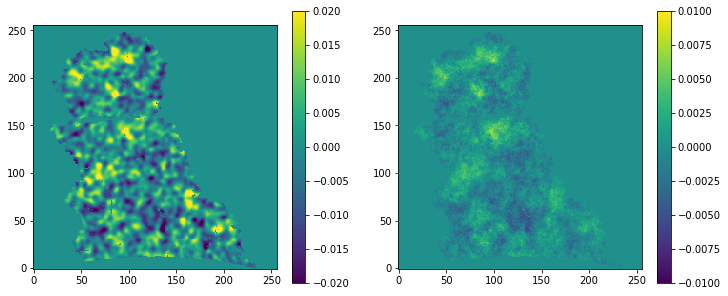

In [12]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_smoothed*sv_mask, origin='lower', clim = (-0.02,0.02)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(wiener_map_sv*sv_mask, origin='lower', clim = (-0.01,0.01)), plt.colorbar()

# Apply model

In [13]:
test_output_rescaled = apply_deepmass(wiener_map_sv, model)

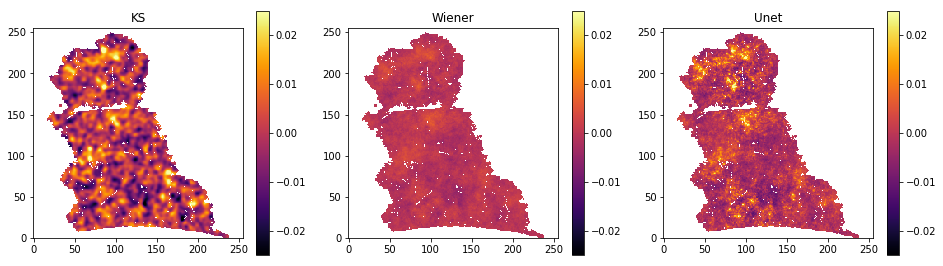

In [15]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('KS')
_ = plt.imshow(np.where(sv_mask!=0.,ks_smoothed,np.nan), origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener')
_ = plt.imshow(np.where(sv_mask!=0.,wiener_map_sv,np.nan), origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('Unet')
_ = plt.imshow(np.where(sv_mask!=0.,test_output_rescaled,np.nan), origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()


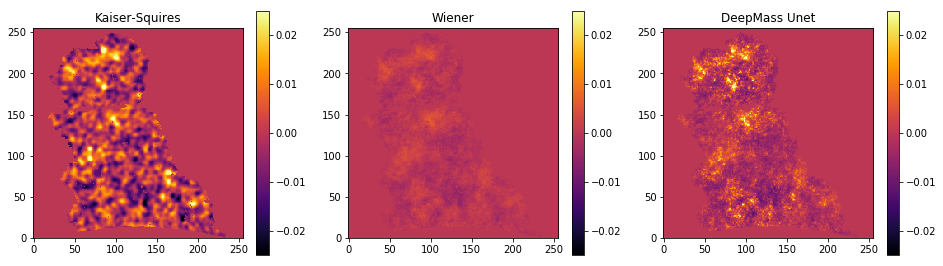

In [16]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('Kaiser-Squires')
_ = plt.imshow(sv_mask*ks_smoothed, origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener')
_ = plt.imshow(sv_mask*wiener_map_sv, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('DeepMass Unet')
_ = plt.imshow(sv_mask*test_output_rescaled, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()


# Apply to Mice

In [17]:
e1_mice_map = -np.load('../mice_mock/sv_patches/e1_noisy_030419_0.npy')
e2_mice_map = -np.load('../mice_mock/sv_patches/e2_noisy_030419_0.npy')
kappa_mice_map = np.load('../mice_mock/sv_patches/kappa_true_030419_0.npy')

In [18]:
ks_mice = ld.ks(e1_mice_map + 1j*e2_mice_map).real
ks_mice_smoothed = ndimage.gaussian_filter(ks_mice, sigma=10./4.5)
wiener_mice_sv, _  = wiener.filtering(e1_mice_map, e2_mice_map, power_map, Ncov, 30)

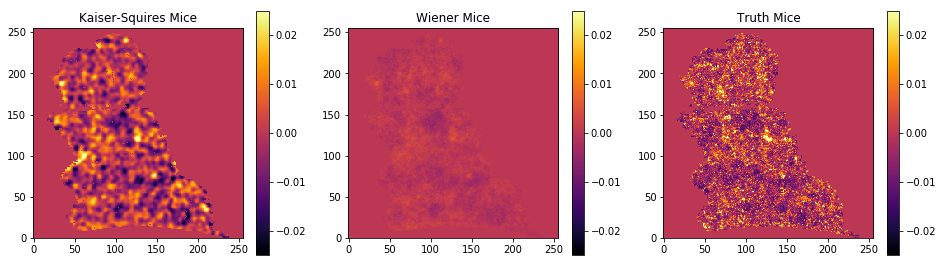

In [19]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('Kaiser-Squires Mice')
_ = plt.imshow(sv_mask*ks_mice_smoothed, origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener Mice')
_ = plt.imshow(sv_mask*wiener_mice_sv, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('Truth Mice')
_ = plt.imshow(sv_mask*kappa_mice_map, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()


In [21]:
mice_output_rescaled = apply_deepmass(wiener_mice_sv, model)

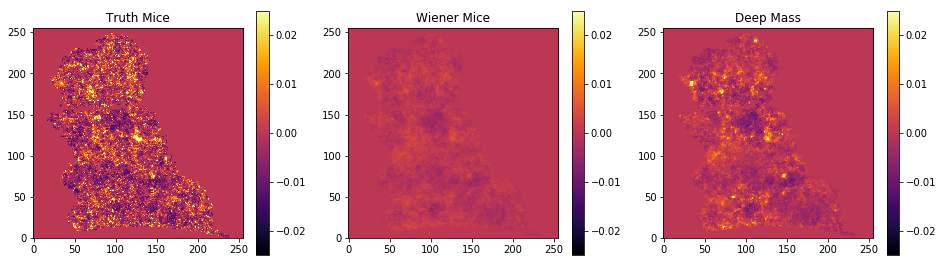

In [22]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('Truth Mice')
_ = plt.imshow(sv_mask*kappa_mice_map, origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener Mice')
_ = plt.imshow(sv_mask*wiener_mice_sv, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('Deep Mass')
_ = plt.imshow(sv_mask*mice_output_rescaled, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()


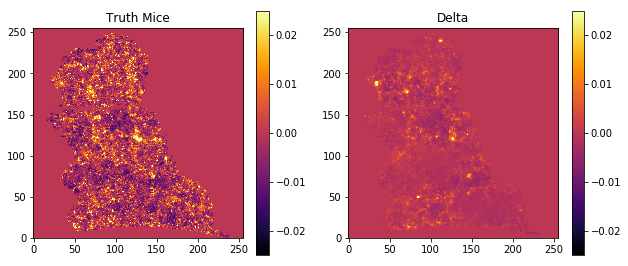

In [23]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('Truth Mice')
_ = plt.imshow(sv_mask*kappa_mice_map, origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Delta')
_ = plt.imshow(sv_mask*mice_output_rescaled - sv_mask*wiener_mice_sv , origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()


# Stats

In [24]:
def flatten_mask(map_array, mask):
    map_array = map_array.flatten()
    return map_array[np.where(mask.flatten()>0.5)]

In [25]:
flattened_masked_truth = flatten_mask(kappa_mice_map, sv_mask)
flattened_masked_ks = flatten_mask(ks_mice_smoothed, sv_mask)
flattened_masked_wiener = flatten_mask(wiener_mice_sv, sv_mask)
flattened_masked_deepmass = flatten_mask(mice_output_rescaled, sv_mask)

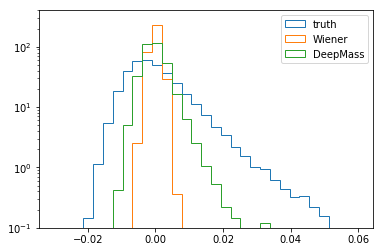

In [26]:
_ = plt.hist(flattened_masked_truth, np.linspace(-0.03,0.06,32), histtype='step', label='truth', density=True)
_ = plt.hist(flattened_masked_wiener, np.linspace(-0.03,0.06,32), histtype='step', label='Wiener', density=True)
_ = plt.hist(flattened_masked_deepmass, np.linspace(-0.03,0.06,32), histtype='step',
             label='DeepMass', density=True)
plt.yscale('log')
plt.ylim(0.1,400)
_ = plt.legend()

In [27]:
print('MSE KS: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_ks)))
print('MSE Wiener: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_wiener)))
print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_deepmass)))

MSE KS: 0.00010224475434578727
MSE Wiener: 7.393967681660081e-05
MSE DeepMass: 7.288605315114221e-05


In [28]:
print('MSE KS: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_ks)))
print('MSE Wiener: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_wiener)))
print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_deepmass)))

MSE KS: 0.00010224475434578727
MSE Wiener: 7.393967681660081e-05
MSE DeepMass: 7.288605315114221e-05


In [29]:
print('Pearson KS: ' + str(pearsonr(flattened_masked_truth, flattened_masked_ks)))
print('Pearson Wiener: ' + str(pearsonr(flattened_masked_truth, flattened_masked_wiener)))
print('Pearson DeepMass: ' + str(pearsonr(flattened_masked_truth, flattened_masked_deepmass)))

Pearson KS: (0.2716025267403879, 0.0)
Pearson Wiener: (0.32065811779504905, 0.0)
Pearson DeepMass: (0.325165403310186, 0.0)


In [30]:
print(np.median(np.absolute(flattened_masked_truth -flattened_masked_ks )))
print(np.median(np.absolute(flattened_masked_truth -flattened_masked_wiener )))
print(np.median(np.absolute(flattened_masked_truth -flattened_masked_deepmass )))

0.006070460866218106
0.004760797765870856
0.004757147515192628


In [31]:
print(np.mean(np.absolute(flattened_masked_truth -flattened_masked_ks )))
print(np.mean(np.absolute(flattened_masked_truth -flattened_masked_wiener )))
print(np.mean(np.absolute(flattened_masked_truth -flattened_masked_deepmass )))

0.007631427136232882
0.006105144818647435
0.006136298858987043


# Loop over all Mice

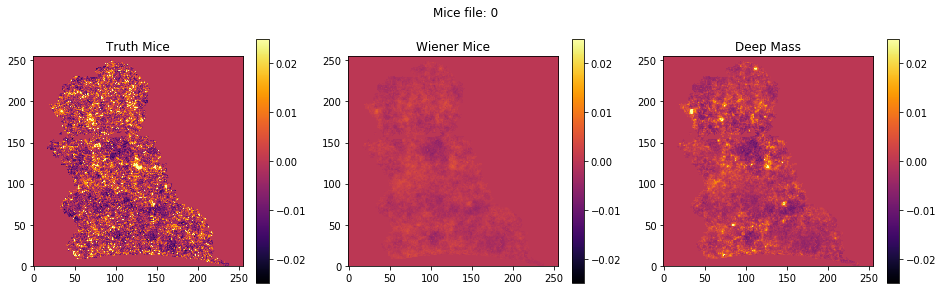

MSE KS: 0.00011051095225334253
MSE Wiener: 7.393967681660081e-05
MSE DeepMass: 7.288605315114221e-05
Pearson KS: (0.18835471864242886, 9.680452630764911e-224)
Pearson Wiener: (0.32065811779504905, 0.0)
Pearson DeepMass: (0.325165403310186, 0.0)
Reduced: 34.201403493243966, 4.606253964843561
variance ratio: 0.02696207122182262, 0.19734048270067317
MAE (median): 0.004760797765870856, 0.004757147515192628


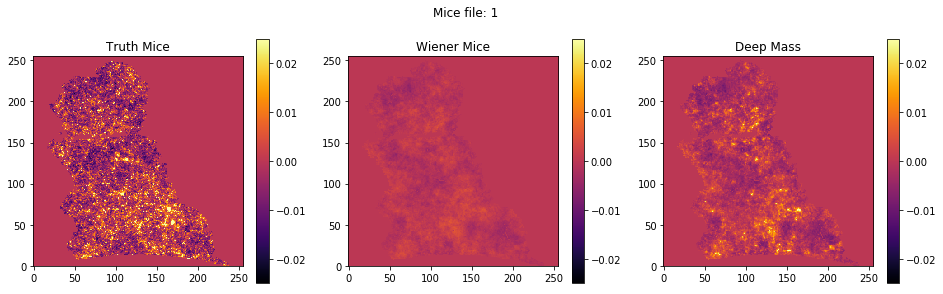

MSE KS: 0.0001129822718904412
MSE Wiener: 7.297977022060162e-05
MSE DeepMass: 7.409225225357683e-05
Pearson KS: (0.12589705538623736, 4.3888101848310203e-100)
Pearson Wiener: (0.3025188898603416, 0.0)
Pearson DeepMass: (0.2992011042351955, 0.0)
Reduced: 27.902412610839747, 4.398459466554349
variance ratio: 0.0331720266824725, 0.2136404448152597
MAE (median): 0.005072356872287647, 0.004991168505512178


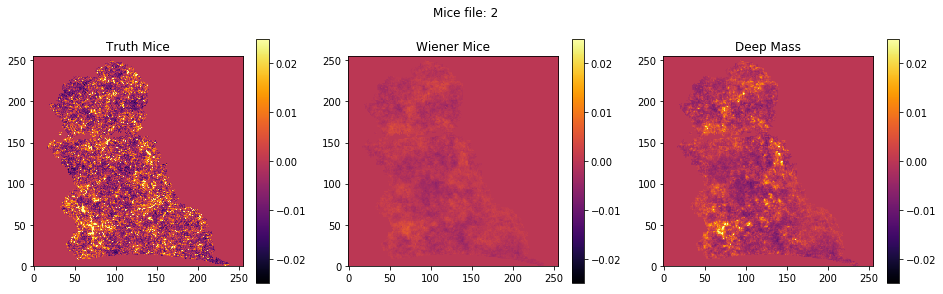

MSE KS: 0.00012534692370104466
MSE Wiener: 7.687116103104919e-05
MSE DeepMass: 7.626261100705446e-05
Pearson KS: (0.11830330996988822, 1.615095188585808e-88)
Pearson Wiener: (0.2973894164608904, 0.0)
Pearson DeepMass: (0.31077376597953427, 0.0)
Reduced: 31.59996877395187, 4.864973783424178
variance ratio: 0.029379890172697917, 0.18932350967460276
MAE (median): 0.004904014065142473, 0.004882995039224625


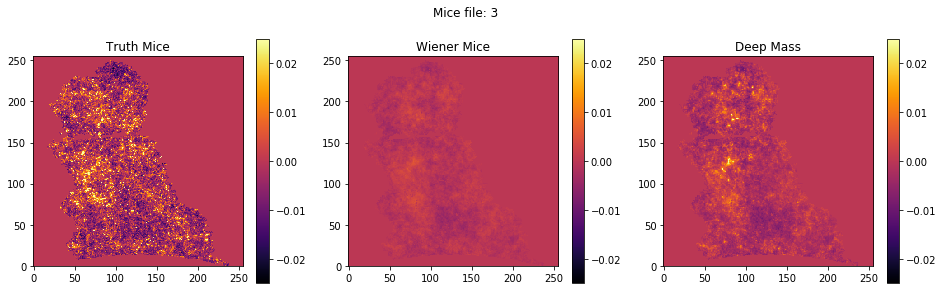

MSE KS: 0.00010489576967788048
MSE Wiener: 6.952379942212987e-05
MSE DeepMass: 6.87698371113636e-05
Pearson KS: (0.12043089492699584, 1.1017452960269133e-91)
Pearson Wiener: (0.301982017747959, 0.0)
Pearson DeepMass: (0.29833511625074866, 0.0)
Reduced: 32.41060341897894, 6.183569284146179
variance ratio: 0.02865397932039185, 0.1485584386770294
MAE (median): 0.004990108745375343, 0.004807709017768502


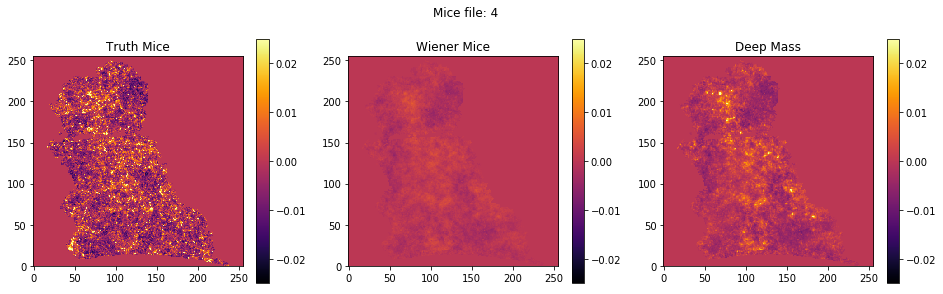

MSE KS: 0.00010666098026164445
MSE Wiener: 6.673953560793989e-05
MSE DeepMass: 6.808314206940353e-05
Pearson KS: (0.1062035028633247, 1.3152411551766036e-71)
Pearson Wiener: (0.27956229549613903, 0.0)
Pearson DeepMass: (0.269655286411131, 0.0)
Reduced: 27.75172220475777, 5.159354994930433
variance ratio: 0.03413615764583197, 0.18731198839463992
MAE (median): 0.005016842904460318, 0.00491410704307782


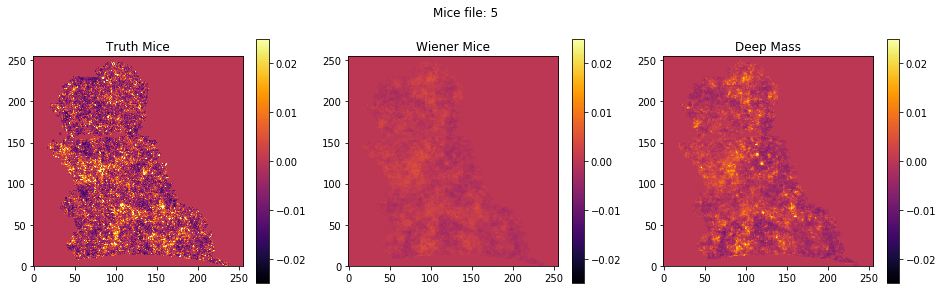

MSE KS: 0.0001073332767564853
MSE Wiener: 6.686872622171647e-05
MSE DeepMass: 6.970907739662414e-05
Pearson KS: (0.12173107054200856, 1.1989207944474512e-93)
Pearson Wiener: (0.23927314971814778, 0.0)
Pearson DeepMass: (0.23412281201072213, 0.0)
Reduced: 31.93058174868477, 5.433480445071719
variance ratio: 0.030049850490818073, 0.1840930201853002
MAE (median): 0.004980561911367367, 0.0050209161709062755


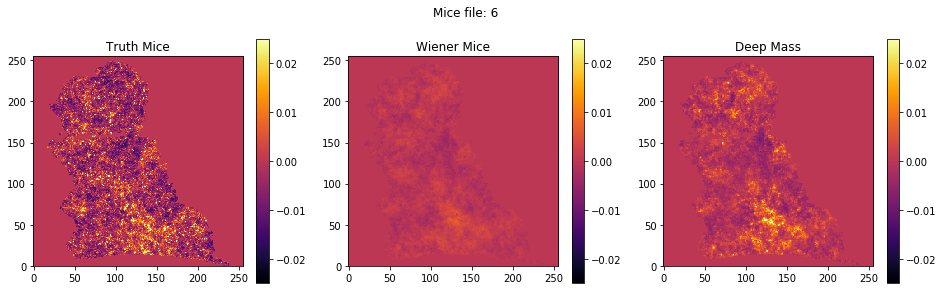

MSE KS: 0.0001119418615281629
MSE Wiener: 6.729254568130553e-05
MSE DeepMass: 6.939461136209171e-05
Pearson KS: (0.10874518835918064, 5.258274465340999e-75)
Pearson Wiener: (0.3193385247128199, 0.0)
Pearson DeepMass: (0.30673843666172623, 0.0)
Reduced: 27.436831749314926, 4.325947646611649
variance ratio: 0.034580859321178326, 0.2261763919858251
MAE (median): 0.005172305661644547, 0.0051717087626457214


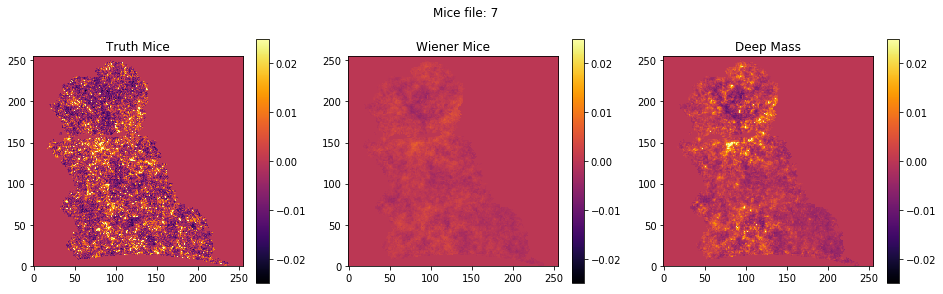

MSE KS: 0.00011279224696954096
MSE Wiener: 7.18374967387837e-05
MSE DeepMass: 7.514674067929619e-05
Pearson KS: (0.13307454094609805, 1.072455751691191e-111)
Pearson Wiener: (0.2940461992624083, 0.0)
Pearson DeepMass: (0.28531249468617836, 0.0)
Reduced: 31.462555348609122, 4.045724912005065
variance ratio: 0.02995834870804738, 0.24371063023826564
MAE (median): 0.005148355101493293, 0.005184705834835768


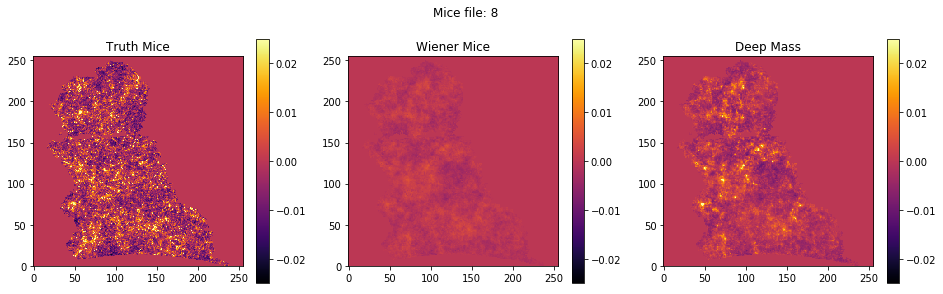

MSE KS: 0.00011053461973130968
MSE Wiener: 6.86413404836341e-05
MSE DeepMass: 7.013325019560734e-05
Pearson KS: (0.12409358532729743, 2.8575802927058876e-97)
Pearson Wiener: (0.2771486139417931, 0.0)
Pearson DeepMass: (0.2746439876532488, 0.0)
Reduced: 32.52938367181094, 4.699429849992924
variance ratio: 0.028990244472438226, 0.20503157660302646
MAE (median): 0.005055668102838562, 0.005028426763601601


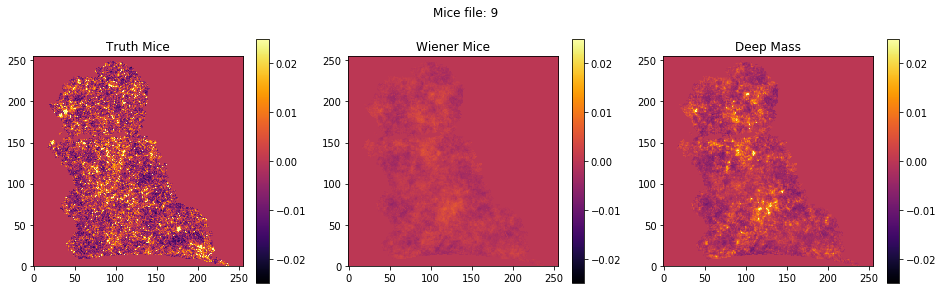

MSE KS: 0.00011312878802537234
MSE Wiener: 7.135060069514331e-05
MSE DeepMass: 7.332060512088393e-05
Pearson KS: (0.10350243668875782, 4.372507853222253e-68)
Pearson Wiener: (0.26576056701160183, 0.0)
Pearson DeepMass: (0.2702859839622348, 0.0)
Reduced: 29.243649626787416, 4.5626353866248115
variance ratio: 0.03204356305751318, 0.21104983424457222
MAE (median): 0.004829018396984096, 0.004923593834973872


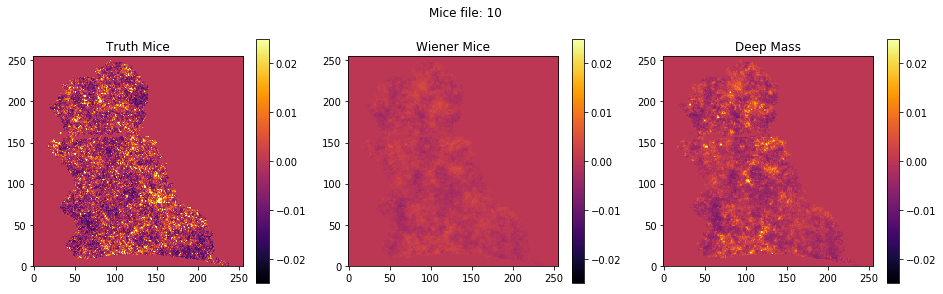

MSE KS: 0.00010952129077019202
MSE Wiener: 6.722474266272096e-05
MSE DeepMass: 6.888102364709041e-05
Pearson KS: (0.09759938404972984, 1.0399706932887866e-60)
Pearson Wiener: (0.2786423618326645, 0.0)
Pearson DeepMass: (0.25979874124427327, 0.0)
Reduced: 34.25507048432841, 5.270575078999976
variance ratio: 0.027529224770333014, 0.1833290496644834
MAE (median): 0.0049583144308219095, 0.00485152518376708


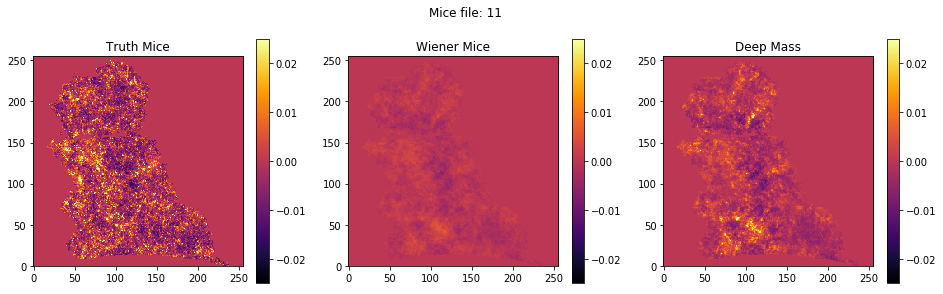

MSE KS: 0.00010941303555850912
MSE Wiener: 6.992845310476637e-05
MSE DeepMass: 7.112740411919418e-05
Pearson KS: (0.1636394181980655, 1.2191151301655354e-168)
Pearson Wiener: (0.3080522801359074, 0.0)
Pearson DeepMass: (0.30083646811566284, 0.0)
Reduced: 29.049832985433994, 4.251663219500832
variance ratio: 0.031771075536849706, 0.22080034034898197
MAE (median): 0.004964210475585304, 0.004869558702921495


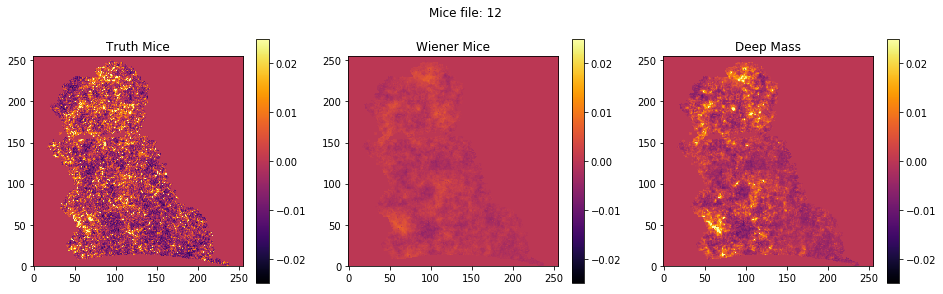

MSE KS: 0.00011500351143981641
MSE Wiener: 7.0349397181896e-05
MSE DeepMass: 7.253342156007858e-05
Pearson KS: (0.1490670297213336, 5.754243418090021e-140)
Pearson Wiener: (0.3533964627133057, 0.0)
Pearson DeepMass: (0.34878584077462116, 0.0)
Reduced: 24.530398609895506, 2.8796181133667575
variance ratio: 0.0367533553212209, 0.32280814646066186
MAE (median): 0.004902797364144576, 0.004923436674289405


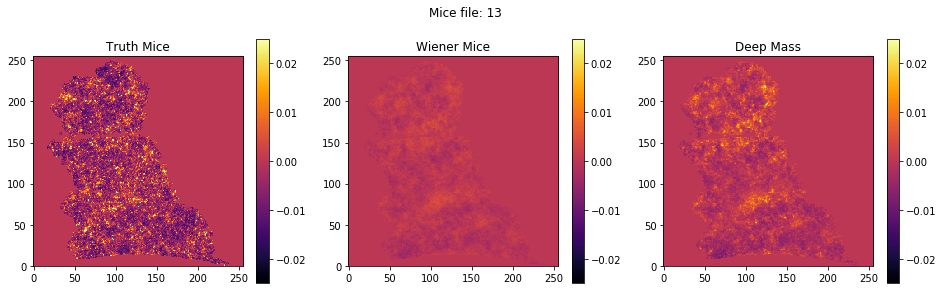

MSE KS: 0.00011026707932626426
MSE Wiener: 6.440570815981001e-05
MSE DeepMass: 6.645342660740214e-05
Pearson KS: (0.09612980065788503, 6.098245981193179e-59)
Pearson Wiener: (0.2391428068063472, 0.0)
Pearson DeepMass: (0.23852563406288674, 0.0)
Reduced: 31.75402249994817, 6.076343855776204
variance ratio: 0.0333636744322112, 0.17989674299079256
MAE (median): 0.005521165190310278, 0.005434186678030528


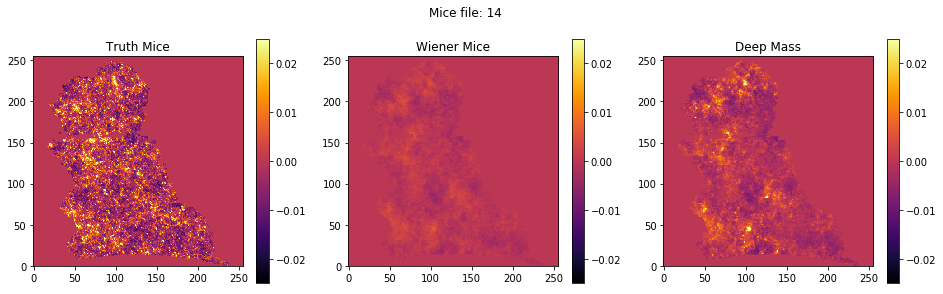

MSE KS: 0.00011495017548983896
MSE Wiener: 7.177659016204755e-05
MSE DeepMass: 7.163624753187639e-05
Pearson KS: (0.10232207978704813, 1.4151163450706526e-66)
Pearson Wiener: (0.319976517259402, 0.0)
Pearson DeepMass: (0.31258593224407427, 0.0)
Reduced: 30.661981233567914, 4.915766068710723
variance ratio: 0.030048401691211077, 0.18705976654003825
MAE (median): 0.004742586883656341, 0.004716947747510858


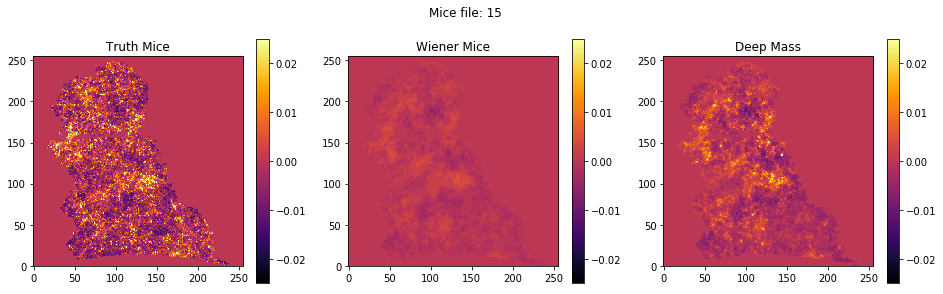

MSE KS: 0.00011970489748104047
MSE Wiener: 7.424195019604114e-05
MSE DeepMass: 7.356168184261982e-05
Pearson KS: (0.12659220528406828, 3.5211233802661286e-101)
Pearson Wiener: (0.33338562550774337, 0.0)
Pearson DeepMass: (0.3307145215157881, 0.0)
Reduced: 29.994403955179504, 4.400343169893008
variance ratio: 0.030479149802551172, 0.20585376566430386
MAE (median): 0.004877098740933143, 0.0048549051862210035


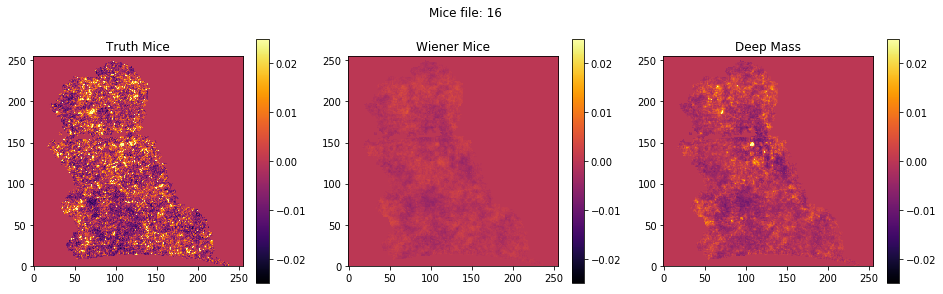

MSE KS: 0.00011567889568370658
MSE Wiener: 7.500021903422085e-05
MSE DeepMass: 7.373642472584582e-05
Pearson KS: (0.1348899323065301, 9.731639628917983e-115)
Pearson Wiener: (0.2855530166175005, 0.0)
Pearson DeepMass: (0.3043875169529803, 0.0)
Reduced: 35.24481723952642, 5.896084036607361
variance ratio: 0.02648970435990752, 0.1556783620928319
MAE (median): 0.00489715626724593, 0.0047751234378665686


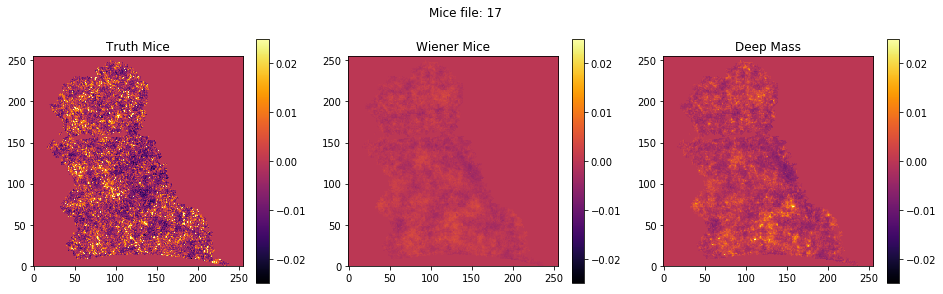

MSE KS: 0.00011043233660878287
MSE Wiener: 6.51026789253277e-05
MSE DeepMass: 6.725723112489752e-05
Pearson KS: (0.057085167818500995, 8.093536291850434e-22)
Pearson Wiener: (0.18447059047726613, 1.5518391460761694e-214)
Pearson DeepMass: (0.18907715412776155, 1.782980022526228e-225)
Reduced: 33.689449053121756, 6.949627880517203
variance ratio: 0.029407942762188798, 0.14727774522348658
MAE (median): 0.0051789571176834685, 0.00516922608949244


In [32]:
wiener_mse = []
deepmass_mse = []
wiener_pearson = []
deepmass_pearson = []
wiener_reduced = []
deepmass_reduced = []
wiener_var_ratio= []
deepmass_var_ratio = []
wiener_mae= []
deepmass_mae = []

for i in range(18):
    
    e1_mice_map_temp = -np.load('../mice_mock/sv_patches/e1_noisy_030419_'+str(i)+'.npy')
    e2_mice_map_temp = -np.load('../mice_mock/sv_patches/e2_noisy_030419_'+str(i)+'.npy')
    kappa_mice_map_temp = np.load('../mice_mock/sv_patches/kappa_true_030419_'+str(i)+'.npy')
    ks_mice_temp = ld.ks(e1_mice_map_temp + 1j*e1_mice_map_temp).real
    ks_mice_smoothed_temp = ndimage.gaussian_filter(ks_mice_temp, sigma=10./4.5)
    wiener_mice_sv_temp, _  = wiener.filtering(e1_mice_map_temp, e2_mice_map_temp, power_map, Ncov, 30)
    mice_output_rescaled_temp = apply_deepmass(wiener_mice_sv_temp, model)
    
#     kappa_mice_map_temp = ndimage.gaussian_filter(kappa_mice_map_temp, sigma=1.)
#     mice_output_rescaled_temp = ndimage.gaussian_filter(mice_output_rescaled_temp, sigma=1.)
#     wiener_mice_sv_temp = ndimage.gaussian_filter(wiener_mice_sv_temp, sigma=1.)
    
    
    _ = plt.figure(figsize =(16,4.5)), plt.suptitle('Mice file: '+str(i))
    _ = plt.subplot(1,3,1), plt.title('Truth Mice')
    _ = plt.imshow(sv_mask*kappa_mice_map_temp, origin='lower',
                   cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
    _ = plt.subplot(1,3,2), plt.title('Wiener Mice')
    _ = plt.imshow(sv_mask*wiener_mice_sv_temp, origin='lower',
                   cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
    _ = plt.subplot(1,3,3), plt.title('Deep Mass')
    _ = plt.imshow(sv_mask*mice_output_rescaled_temp, origin='lower',
                   cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
    _ =plt.show()
    
    flattened_truth_temp = flatten_mask(kappa_mice_map_temp, sv_mask)
    flattened_ks_temp = flatten_mask(ks_mice_smoothed_temp, sv_mask)
    flattened_wiener_temp = flatten_mask(wiener_mice_sv_temp, sv_mask)
    flattened_deepmass_temp = flatten_mask(mice_output_rescaled_temp, sv_mask)
    
    print('MSE KS: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_ks_temp)))
    print('MSE Wiener: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_wiener_temp)))
    print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_deepmass_temp)))
    
    wiener_mse.append(mf.mean_square_error(flattened_truth_temp, flattened_wiener_temp))
    deepmass_mse.append(mf.mean_square_error(flattened_truth_temp, flattened_deepmass_temp))
    
    print('Pearson KS: ' + str(pearsonr(flattened_truth_temp, flattened_ks_temp)))
    print('Pearson Wiener: ' + str(pearsonr(flattened_truth_temp, flattened_wiener_temp)))
    print('Pearson DeepMass: ' + str(pearsonr(flattened_truth_temp, flattened_deepmass_temp)))

    wiener_pearson.append(pearsonr(flattened_truth_temp, flattened_wiener_temp)[0])
    deepmass_pearson.append(pearsonr(flattened_truth_temp, flattened_deepmass_temp)[0])
    
    
    wiener_reduced.append(mf.mean_square_error(flattened_truth_temp,
                                               flattened_wiener_temp)/np.var(flattened_wiener_temp))
    
    deepmass_reduced.append(mf.mean_square_error(flattened_truth_temp,
                                               flattened_deepmass_temp)/np.var(flattened_deepmass_temp))
    
    print('Reduced: ' + str(wiener_reduced[-1])+', ' + str(deepmass_reduced[-1]))
    
    
    wiener_var_ratio.append(np.var(flattened_wiener_temp)/np.var(flattened_truth_temp))
    deepmass_var_ratio.append(np.var(flattened_deepmass_temp)/np.var(flattened_truth_temp))
    print('variance ratio: ' + str(wiener_var_ratio[-1])+', ' + str(deepmass_var_ratio[-1]))
    
    
    wiener_mae.append(np.median(np.absolute(flattened_truth_temp - flattened_wiener_temp)))
    deepmass_mae.append(np.median(np.absolute(flattened_truth_temp - flattened_deepmass_temp)))
    print('MAE (median): ' + str(wiener_mae[-1])+', ' + str(deepmass_mae[-1]))


In [33]:
print(np.mean(np.array(wiener_mse)), np.std(np.array(wiener_mse), ddof=1))
print(np.mean(np.array(deepmass_mse)), np.std(np.array(deepmass_mse), ddof=1))

7.022635513031861e-05 3.556199556684268e-06
7.127694675033605e-05 2.8334497163528597e-06


In [34]:
print(np.mean(np.array(wiener_pearson)), np.std(np.array(wiener_pearson), ddof=1))
print(np.mean(np.array(deepmass_pearson)), np.std(np.array(deepmass_pearson), ddof=1))

0.2889054140754048 0.039543586723040675
0.2866081222332752 0.03893668765591056


In [35]:
print(np.mean(np.array(wiener_reduced)), np.std(np.array(wiener_reduced), ddof=1))
print(np.mean(np.array(deepmass_reduced)), np.std(np.array(deepmass_reduced), ddof=1))

30.869393817110065 2.8163176570462127
4.939991730976497 0.939007857635741


In [36]:
print(np.mean(np.array(wiener_var_ratio)), np.std(np.array(wiener_var_ratio), ddof=1))
print(np.mean(np.array(deepmass_var_ratio)), np.std(np.array(deepmass_var_ratio), ddof=1))

0.030764973320538083 0.0028003570414762593
0.2004966798058208 0.040035637375265776


In [37]:
print(np.mean(np.array(wiener_mae)), np.std(np.array(wiener_mae), ddof=1))
print(np.mean(np.array(deepmass_mae)), np.std(np.array(deepmass_mae), ddof=1))

0.004998461999880303 0.00018221903925730076
0.004959854899324354 0.00018352607358505704
